In [36]:
#If on VS code, please download Markdown as the extension to view the math in this file properly

#scipy is a library that uses numpy for more mathematical functions and is used for scientific computing like linear algebra, integration, optimization, etc.
import scipy as sc
# These are going to be your necessary imports for this project
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# This is the library we are going to use to get the stock data, if you don't have it installed, you can install it by running 'pip install yfinance'
import yfinance as yf


In [120]:
ticker = "NVDA"  # Change to any ticker
#This is the basic call to yahoo to get the stock data for the ticker you want, please look into yfinance documentation when you can

data = yf.download(ticker, start="2021-01-01", end="2022-01-01")
#here I am printing to show the names of the columns in the data, this is because we will call these columns later. NOTE: An issue that you will find if you try and chat GPT the data is that it will often get these column names wrong, you may have run into this when building your model last Wednesday, this is why it is important to view the data
print(data.head())

#Compute log returns and volatility using "Close" prices
data["Returns"] = np.log(data["Close"] / data["Close"].shift(1))
sigma = np.std(data["Returns"].dropna()) * np.sqrt(252)  # Annualized volatility
initial = data["Close"].iloc[-1]  # Latest stock price
rate = 0.05  # Assume a 5% risk-free rate 


[*********************100%***********************]  1 of 1 completed

Price           Close       High        Low       Open     Volume
Ticker           NVDA       NVDA       NVDA       NVDA       NVDA
Date                                                             
2021-01-04  13.080303  13.617939  12.929685  13.071077  560640000
2021-01-05  13.370816  13.409468  13.053871  13.066588  322760000
2021-01-06  12.582565  13.211469  12.554138  13.189026  580424000
2021-01-07  13.310218  13.343883  12.853877  12.934671  461480000
2021-01-08  13.243139  13.387024  13.008984  13.328673  292528000


In [130]:

def simulation(initial, rate, sigma, Maturity, Steps, SimNum, depth=0, maxDepth=10000):
    '''
    Step Definition: A period in time which the stock price will be recalculated, the more steps, the more accurate the simulation will be. In an ideal world we would have infinite steps, but that is not possible, so we will have to settle for a large number of steps because of computing limitations.
    
    At each step our algorithm will do the following:
    1. Decide if we should exercise the option
    2. Decide if we should wait to exercise the option
    
    This following line of code will calculate the time between each step, it is calculated by the function dT (maturity) = Total Time Period/Steps, an example would be if we had a time period of 1 year, and 50 steps, the time between each step would be 1/50 or 0.2 years per step.
    
    The function will then calculate the stock price at each step, the stock price is calculated by the formula: Figure 1.1
    - The function utilizes Geometric Brownian Motion to recalculate the stock price for a random movement Z, which is from a standard distribution of 
    
    Z ~ N(0,1)
    where N is the normal distribution, and 0,1 are the mean and standard deviation respectively.
    
    '''
    if depth > maxDepth:
        print("Maximum recursion depth reached. Returning default stock paths.")
        return np.full((Steps+1, SimNum), initial)  
    # Return a constant stock price array as a fallback

    timeSteps = Maturity / Steps  
    
    ''' 
    Discount factor is used to calculate the present value of the option, it is calculated by the formula: Figure 1.2
    - The discount factor is always going to be between 0 and 1, where 0 means the option is completely worthless, and 1 means the option has no discounting where it will have the same value today as in the future
    
    '''

    # np.exp is the numpy call for the exponential function, it is used to calculate the discount factor, this is the same format as the formula in Figure 1.2
    discount = np.exp(-rate * timeSteps) 

    # np.zeros is a numpy function that will return an array of zeros with the specified shape, the reason for creating this is to store the stock prices at each step
    stockPaths = np.zeros((Steps+1, SimNum))
    # The first stock price is the initial stock price, so in our stockPaths array, the first row will be the initial stock price, the : means that it will be the same for all columns
    stockPaths[0, :] = initial

    for i in range(1, Steps+1):
        # np.random.standard_normal is a numpy function that will return an array of random numbers from a standard normal distribution N ~ (0,1)
        # This Z value is the same as the Z value in the formula in Figure 1.1, it represents the random movement of the stock price according to the Geometric Brownian Motion
        Z = np.random.standard_normal(SimNum)  
        # This following line does the calculation of the stock price at each step, it is the same as the formula in Figure 1.1, it will update every column at step 'i' with the updated stock price
        #We use sigma here to represent the volatility of the stock, the sigma is the standard deviation of the stock returns, and the rate is the risk-free rate
        stockPaths[i, :] = stockPaths[i-1, :] * np.exp((rate - 0.5 * sigma**2) * timeSteps + sigma * np.sqrt(timeSteps) * Z)

    # np.maximum is a numpy function that will return the maximum value of two arrays, in this case it will return the maximum value of the rate and stockPaths
    payMatrix = np.maximum(np.array(initial) - stockPaths, 0)

    # np.zeros_like is a numpy function that will return an array of zeros with the same shape and type as the input array
    # NOTE: if you try and use np.zeros, you will get an error because the payMatrix is not an integer, it is a float
    optionValue = np.zeros_like(payMatrix)

    # The value of the option at expiration will be the same as 
    optionValue[-1, :] = payMatrix[-1, :]
    # The following loop will calculate the option value at each step, it will start from the second last step and go to the first step, it will then calculate the continuation value and compare it to the intrinsic value
    for i in range(Steps-1, 0, -1):  
        inTheMoney = payMatrix[i, :] > 0  
        # This line will check if the option is in the money, if it is, it will calculate the continuation value
        if np.any(inTheMoney): 
            X = stockPaths[i, inTheMoney]  # Stock prices at time t
            Y = optionValue[i+1, inTheMoney] * discount  # Discounted future option values
            #polynomial regression, we use a degree of 2 because we are trying to fit a quadratic curve to the data, this is because we are trying to find the continuation value
            regressionCoeffs = np.polyfit(X, Y, deg=2) 
            # the polyval function will calculate the value of the polynomial at the stock price X, this is the continuation value at each stock price X 
            continuation_value = np.polyval(regressionCoeffs, X)
            # Exercise if intrinsic value > continuation value
            exercise = payMatrix[i, inTheMoney] > continuation_value
            # If the intrinsic value is greater than the continuation value, we will exercise the option, if not, we will wait
            optionValue[i, inTheMoney] = np.where(exercise, payMatrix[i, inTheMoney], optionValue[i+1, inTheMoney] * discount)
            
    # Find the most optimal ITM value and first step where it occurs
    # Find the step where early exercise provides the highest value
    # Max value per step
    optimal_values = np.max(optionValue, axis=1)  
    # Ignore worthless expiration cases, this is becasue the option expires worthless
    valid_steps = np.where(optimal_values > 0)[0] 

    if len(valid_steps) > 0:
        optimal_step = valid_steps[np.argmax(optimal_values[valid_steps])]  # First occurrence of max value
        optimal_value = optimal_values[optimal_step]
        print(f"Most optimal in-the-money option value: {optimal_value} at step {optimal_step}")
    else:
        print("No in-the-money option value found before expiration.")

    return np.mean(optionValue[1, :]) * discount, stockPaths
    
#THE FOLLOWING IS A SIMULATION OF THE OPTION PRICE AND STOCK PATHS
Maturity = 1.0   # 1 year
Steps = 2520     # 10 updates per day for 252 days (number of trade days in a year)
SimNum = 20000   # 20,000 Monte Carlo simulations

# The simulation function will return the option price and the stock paths, we will store these in the variables option_price and stock_paths, we have the maxDepth for the number of recusions to prevent the function from running forever
option_price, stock_paths = simulation(initial, rate, sigma, Maturity, Steps, SimNum, depth=0, maxDepth=10000)



Most optimal in-the-money option value: 25.030757392257822 at step 2256


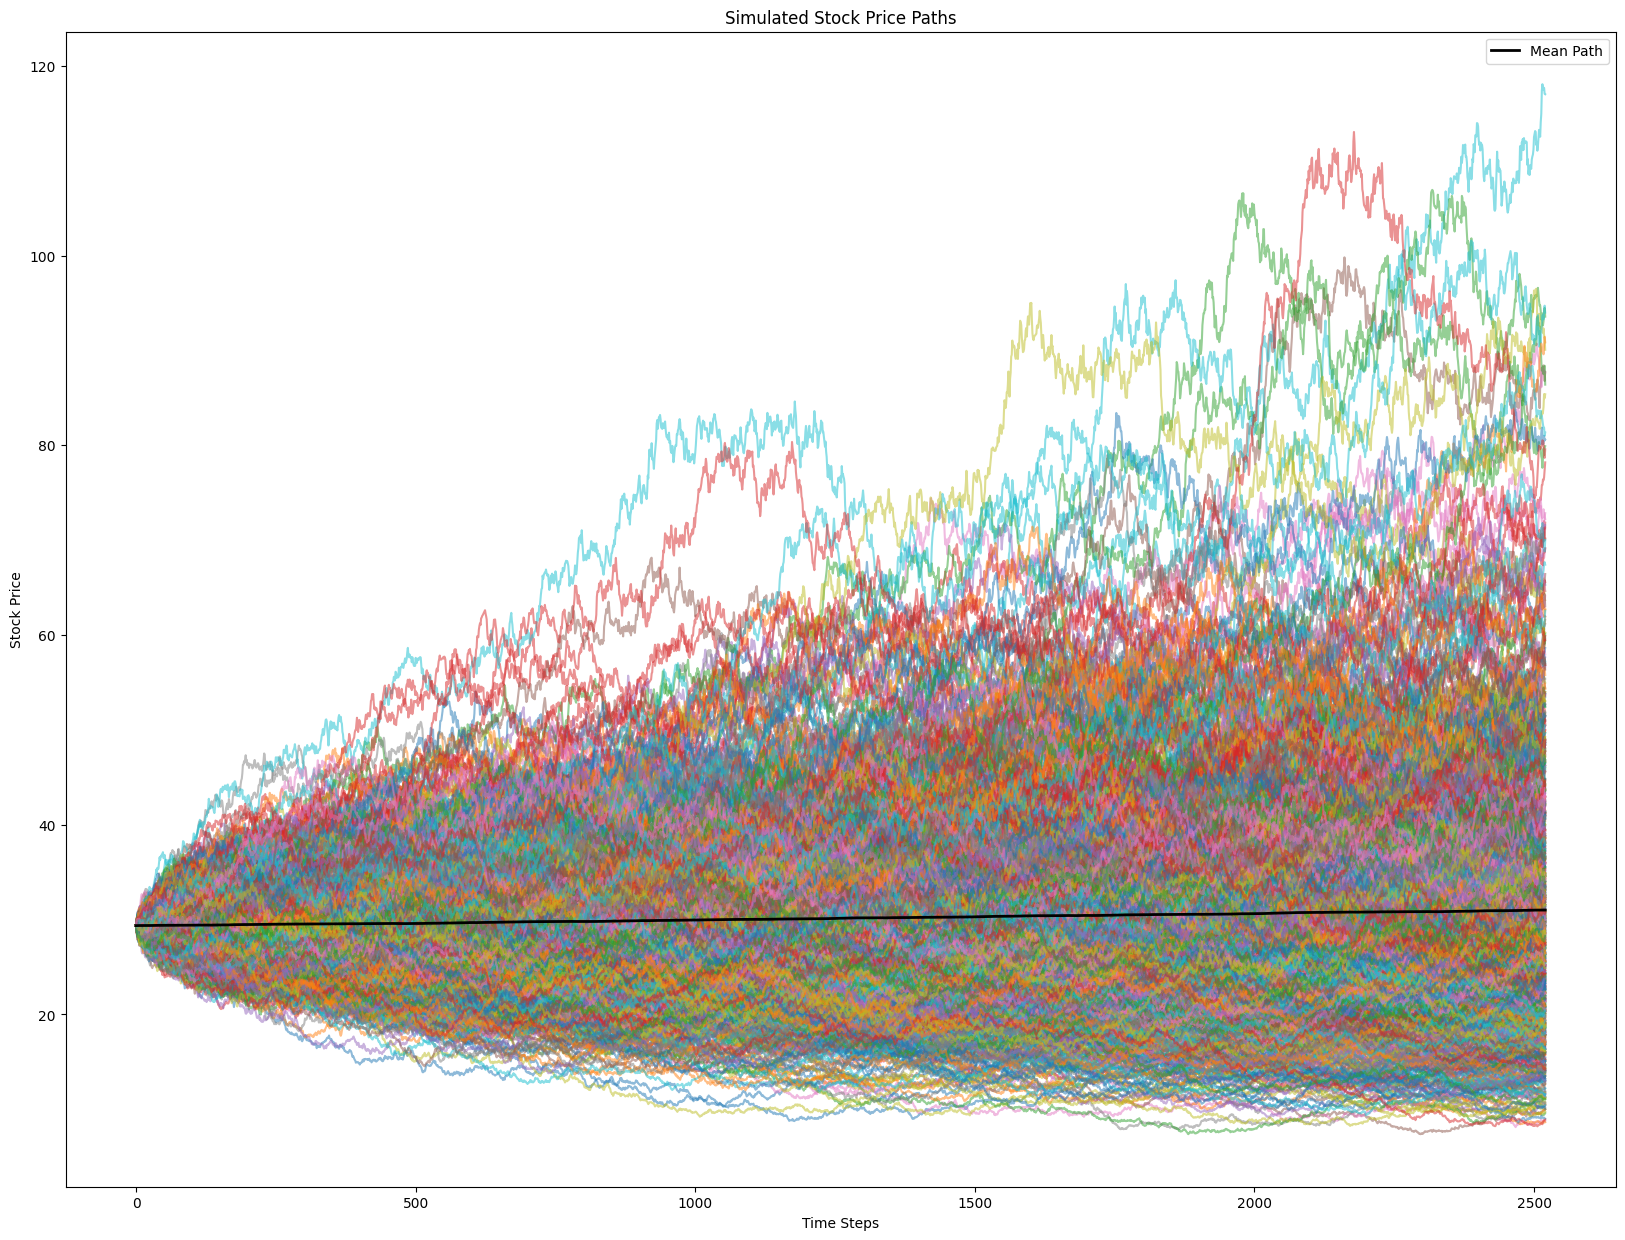

In [137]:
# This function is just to path the stock prices, it will plot a subset of the stock paths and the mean path for reference, you can choose how many of the paths to display
def plot_stock_paths(stockPaths, num_paths=1000):
    plt.figure(figsize=(20, 15))

    # Plot a subset of stock paths (num_paths)
    plt.plot(stockPaths[:, :num_paths], alpha=0.5)

    # Plot mean path for reference
    plt.plot(stockPaths.mean(axis=1), color='black', linewidth=2, label="Mean Path")

    # Labels and title
    plt.xlabel("Time Steps")
    plt.ylabel("Stock Price")
    plt.title("Simulated Stock Price Paths")
    plt.legend()
    plt.show()

# Call the function with the generated stock paths
plot_stock_paths(stock_paths)


In [118]:
from IPython.display import display, Math

print("Figure 1.1 - Stock Price Simulation Formula utilizing GBM")

display(Math(r"S_{t+1} = S_t \times e^{(r - 0.5\sigma^2) dt + \sigma \sqrt{dt} Z}"))

Figure 1.1 - Stock Price Simulation Formula utilizing GBM


<IPython.core.display.Math object>

In [50]:
print("Figure 1.2 - Discount Factor Formula")
display(Math(r"D = e^{-r \cdot T}"))
print(" D = discount factor \n e = eulers number (2.71828) which is for continuous compounding \n r = risk free rate \n T = time to maturity in years")

Figure 1.2 - Discount Factor Formula


<IPython.core.display.Math object>

 D = discount factor 
 e = eulers number (2.71828) which is for continuous compounding 
 r = risk free rate 
 T = time to maturity in years
